In [12]:
#coding:utf8
import os
from PIL import Image
from torch.utils import data
import numpy as np
from torchvision import  transforms as T
import matplotlib.pyplot as plt
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.transforms import *
from torch.utils import data
from torchvision import transforms
from torchvision.models import googlenet
import torch.nn as nn
import datetime
from torchsummary import summary

In [13]:
class DogCat(data.Dataset):
    def __init__(self,root,transforms=None,train=True,test=False):
        self.test = test
        imgs = [os.path.join(root,img) for img in os.listdir(root)] 
        # test1: data/test1/8973.jpg
        # train: data/train/cat.10004.jpg 
        if self.test:
            imgs = sorted(imgs,key=lambda x:int(x.split('.')[-2].split('\\')[-1]))
        else:
            imgs = sorted(imgs,key=lambda x:int(x.split('.')[-2]))  
        imgs_num = len(imgs)
        np.random.seed(100)
        self.imgs = imgs
        if transforms is None:
            if self.test or not train: 
                self.transforms = T.Compose([
                    T.CenterCrop(224),                            
                    T.ToTensor(),                
                    T.Normalize(mean = [0.485, 0.456, 0.406], 
                                     std = [0.229, 0.224, 0.225])
                    ]) 
            else :
                imgs = np.random.permutation(imgs)
                self.transforms = T.Compose([
                    T.CenterCrop(224),
                    T.RandomHorizontalFlip(),
                    T.ToTensor(),
                    T.Normalize(mean = [0.485, 0.456, 0.406], 
                                     std = [0.229, 0.224, 0.225])
                    ])  
    def __getitem__(self,index):
        '''
        一次返回一张图片的数据
        '''
        img_path = self.imgs[index]
        if self.test: label = int(self.imgs[index].split('.')[-2].split('\\')[-1])
        else: label = 1 if 'dog' in img_path.split('\\')[-1] else 0
        data = Image.open(img_path)
        data = self.transforms(data)
        return data, label    
    def __len__(self):
        return len(self.imgs)

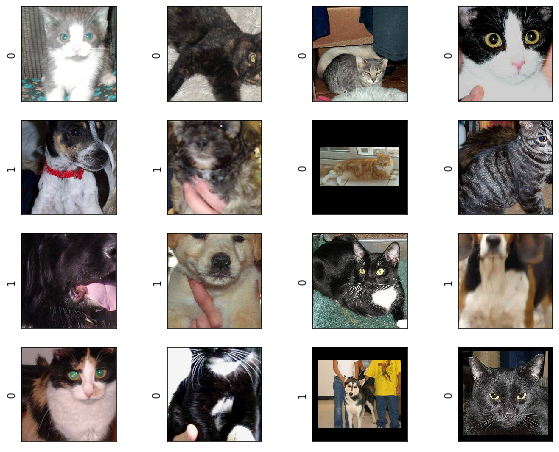

In [14]:
# 1=dog 0=cat
path = r'C:\Users\caeit\Desktop\binru7_1\train'
train_data = DogCat(path,train=True)
train_dataloader = DataLoader(train_data,batch_size=16,shuffle=True)
x,y = next(iter(train_dataloader))
mean = torch.Tensor([0.485, 0.456, 0.406])
std = torch.Tensor([0.229, 0.224, 0.225])

plt.figure(figsize=(10,8))
for j,i in enumerate(x):
    i = torch.transpose(i,2, 0)
    i = torch.transpose(i,0, 1)
    plt.subplot(4,4,j+1)
    plt.xticks([])
    plt.yticks([])
    plt.ylabel(y.data.numpy()[j])
    plt.imshow(i*std+mean)
    

In [4]:
model = googlenet(pretrained=True)
model = model.cuda()
summary(model,(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
       BasicConv2d-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
       BasicConv2d-7           [-1, 64, 56, 56]               0
            Conv2d-8          [-1, 192, 56, 56]         110,592
       BatchNorm2d-9          [-1, 192, 56, 56]             384
      BasicConv2d-10          [-1, 192, 56, 56]               0
        MaxPool2d-11          [-1, 192, 28, 28]               0
           Conv2d-12           [-1, 64, 28, 28]          12,288
      BatchNorm2d-13           [-1, 64, 28, 28]             128
      BasicConv2d-14           [-1, 64,

In [5]:
print(model)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [15]:
model.fc = nn.Linear(in_features=1024, out_features=2, bias=True)

In [16]:
model = model.cuda(2)   #其他GPU被占用，换一个

In [17]:
cost = torch.nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.SGD(model.parameters(),lr=1e-4,momentum=0.9)

start = datetime.datetime.now()
for i in range(20):
        correct = 0.0
        total = 25000
        running_loss = 0.0
        accuracy = 0.0
        print('-----epoch', i+1, '-----')
        for num, image in enumerate(train_dataloader):
            x_train, y_train = image
            x_train = x_train.cuda(2)
            y_train = y_train.cuda(2)
            optimizer.zero_grad()
            output = model(x_train)
            loss = cost(output, y_train)
            _, predicted = torch.max(output, 1)
            correct += (predicted == y_train).sum().item()
            #print(correct)
            if num%100 == 0:
                print(num*16, '/ 25000', 'loss:', running_loss, ',accuracy:{}%'.format((100*correct/25000)),'correct:%s'%correct)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print('-----------Epoch:', i+1, ', one_epoch_loss:', running_loss, '-----------',',accuracy:%f'%(100*correct/25000))
print(datetime.datetime.now()-start)
torch.save(model, '../fine_tuning_20_epoch_dog_cat_googlenet.pkl')

-----epoch 1 -----
0 / 25000 loss: 0.0 ,accuracy:0.028% correct:7.0
1600 / 25000 loss: 62.15833738446236 ,accuracy:4.42% correct:1105.0
3200 / 25000 loss: 108.56654822826385 ,accuracy:10.02% correct:2505.0
4800 / 25000 loss: 146.30141746997833 ,accuracy:15.716% correct:3929.0
6400 / 25000 loss: 178.07818028330803 ,accuracy:21.584% correct:5396.0
8000 / 25000 loss: 205.9600034058094 ,accuracy:27.512% correct:6878.0
9600 / 25000 loss: 231.01365266740322 ,accuracy:33.46% correct:8365.0
11200 / 25000 loss: 253.77364882081747 ,accuracy:39.38% correct:9845.0
12800 / 25000 loss: 275.2553313970566 ,accuracy:45.36% correct:11340.0
14400 / 25000 loss: 295.2084004878998 ,accuracy:51.332% correct:12833.0
16000 / 25000 loss: 314.24107947945595 ,accuracy:57.348% correct:14337.0
17600 / 25000 loss: 331.3076120875776 ,accuracy:63.392% correct:15848.0
19200 / 25000 loss: 347.0090423710644 ,accuracy:69.468% correct:17367.0
20800 / 25000 loss: 362.74398124963045 ,accuracy:75.572% correct:18893.0
22400 / 

19200 / 25000 loss: 88.78728434443474 ,accuracy:74.748% correct:18687.0
20800 / 25000 loss: 96.10689680464566 ,accuracy:80.956% correct:20239.0
22400 / 25000 loss: 103.38902997225523 ,accuracy:87.176% correct:21794.0
24000 / 25000 loss: 110.25180808827281 ,accuracy:93.392% correct:23348.0
-----------Epoch: 7 , one_epoch_loss: 115.80807833187282 ----------- ,accuracy:97.180000
-----epoch 8 -----
0 / 25000 loss: 0.0 ,accuracy:0.064% correct:16.0
1600 / 25000 loss: 5.60460589826107 ,accuracy:6.332% correct:1583.0
3200 / 25000 loss: 12.492667514830828 ,accuracy:12.572% correct:3143.0
4800 / 25000 loss: 18.35530523583293 ,accuracy:18.844% correct:4711.0
6400 / 25000 loss: 24.133800083771348 ,accuracy:25.112% correct:6278.0
8000 / 25000 loss: 31.717520222067833 ,accuracy:31.356% correct:7839.0
9600 / 25000 loss: 39.84275006316602 ,accuracy:37.564% correct:9391.0
11200 / 25000 loss: 46.517725663259625 ,accuracy:43.8% correct:10950.0
12800 / 25000 loss: 53.806634245440364 ,accuracy:50.028% cor

11200 / 25000 loss: 36.288643941283226 ,accuracy:43.92% correct:10980.0
12800 / 25000 loss: 40.90499274805188 ,accuracy:50.228% correct:12557.0
14400 / 25000 loss: 47.85650430992246 ,accuracy:56.524% correct:14131.0
16000 / 25000 loss: 53.70509774796665 ,accuracy:62.772% correct:15693.0
17600 / 25000 loss: 58.83558134920895 ,accuracy:69.052% correct:17263.0
19200 / 25000 loss: 63.700784020125866 ,accuracy:75.344% correct:18836.0
20800 / 25000 loss: 67.72003781795502 ,accuracy:81.644% correct:20411.0
22400 / 25000 loss: 71.97766358032823 ,accuracy:87.932% correct:21983.0
24000 / 25000 loss: 77.43819906190038 ,accuracy:94.24% correct:23560.0
-----------Epoch: 14 , one_epoch_loss: 81.05082648433745 ----------- ,accuracy:98.084000
-----epoch 15 -----
0 / 25000 loss: 0.0 ,accuracy:0.064% correct:16.0
1600 / 25000 loss: 5.634920816868544 ,accuracy:6.304% correct:1576.0
3200 / 25000 loss: 10.824543314054608 ,accuracy:12.62% correct:3155.0
4800 / 25000 loss: 14.654143774881959 ,accuracy:18.924

C:\Users\caeit\.conda\envs\pytorch_env\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type GoogLeNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\caeit\.conda\envs\pytorch_env\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BasicConv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\caeit\.conda\envs\pytorch_env\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\caeit\.conda\envs\pytorch_env\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BatchNorm2d. It won't be checked for correctness upon loading.

# 测试

In [18]:
model = torch.load(r'C:\Users\caeit\Desktop\fine_tuning_20_epoch_dog_cat_googlenet.pkl')
model = model.cuda()

path = r'C:\Users\caeit\Desktop\binru7_1\test1'
test_data = DogCat(path,train=False,test=True)
test_dataloader = DataLoader(test_data,batch_size=16,shuffle=False,num_workers=0)

result = []
start = datetime.datetime.now()
for num, image in enumerate(test_dataloader):
    x_train, y_train = image
    x_train = x_train.cuda()
    y_train = y_train.cuda()

    output = model(x_train)

    _, predicted = torch.max(output, 1)
    result.append(predicted)
print(datetime.datetime.now()-start)
result1 = []
for i in result:
    i = i.cpu()
    for j in i.data.numpy():
        result1.append(j)


for j,i in enumerate(result1):
    if i == 0:
        result1[j] = 0.05
    else:
        result1[j] = 0.95
np.savetxt("googlenet.csv", result1, delimiter=',')

0:02:48.892372


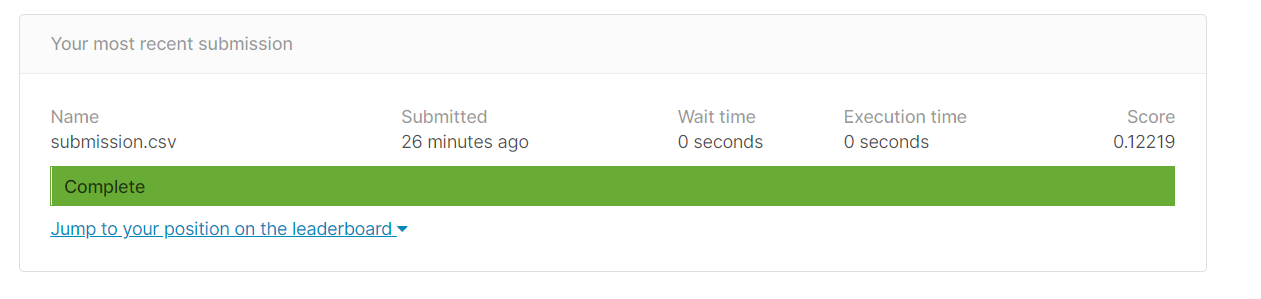